In [1]:
import numpy as np
import deepchem as dc
import numpy as np
from deepchem.feat import GraphData
import pandas as pd
from deepchem.feat import DMPNNFeaturizer
import deepchem as dc

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [2]:
def get_graphs(weighted_adj_matrix):
    node_features = weighted_adj_matrix.diagonal().reshape(-1, 1)
    edges = np.array(np.nonzero(weighted_adj_matrix))
    edge_weights = weighted_adj_matrix[edges.T[:, 0], edges.T[:, 1]]
    graph = GraphData(node_features=node_features, edge_index=edges, edge_features=edge_weights.reshape(-1, 1))
    return graph

In [3]:
TASKS = [
'alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy',
'bergamot', 'berry', 'bitter', 'black currant', 'brandy', 'burnt',
'buttery', 'cabbage', 'camphoreous', 'caramellic', 'cedar', 'celery',
'chamomile', 'cheesy', 'cherry', 'chocolate', 'cinnamon', 'citrus', 'clean',
'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling',
'cortex', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy',
'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruit skin',
'fruity', 'garlic', 'gassy', 'geranium', 'grape', 'grapefruit', 'grassy',
'green', 'hawthorn', 'hay', 'hazelnut', 'herbal', 'honey', 'hyacinth',
'jasmin', 'juicy', 'ketonic', 'lactonic', 'lavender', 'leafy', 'leathery',
'lemon', 'lily', 'malty', 'meaty', 'medicinal', 'melon', 'metallic',
'milky', 'mint', 'muguet', 'mushroom', 'musk', 'musty', 'natural', 'nutty',
'odorless', 'oily', 'onion', 'orange', 'orangeflower', 'orris', 'ozone',
'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn',
'potato', 'powdery', 'pungent', 'radish', 'raspberry', 'ripe', 'roasted',
'rose', 'rummy', 'sandalwood', 'savory', 'sharp', 'smoky', 'soapy',
'solvent', 'sour', 'spicy', 'strawberry', 'sulfurous', 'sweaty', 'sweet',
'tea', 'terpenic', 'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable',
'vetiver', 'violet', 'warm', 'waxy', 'weedy', 'winey', 'woody'
]
print("No of tasks: ", len(TASKS))

No of tasks:  138


In [4]:
import deepchem as dc
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio

In [6]:
from deepchem.feat import DMPNNFeaturizer
import deepchem as dc


featurizer = DMPNNFeaturizer()

smiles_field = 'nonStereoSMILES'


loader = dc.data.CSVLoader(
    tasks=TASKS,  
    feature_field=smiles_field,
    featurizer=featurizer
)



In [7]:

dataset = loader.create_dataset(inputs=["DMPNNpruned_without hydrogen_curated_GS_LF_merged_4812_QM_cleaned.csv"])
n_tasks = len(dataset.tasks)
dataset.X
len(dataset.X)


4812

In [8]:
data = np.load("DMPNNpruned_graph_data_cleaned.npz",allow_pickle=True)
mtx_list = data['mtx']
qm_graphs = []
for mtx in mtx_list:
    qm_graphs.append(get_graphs(mtx))
QM_X = np.asarray(qm_graphs)
QM_X
len(QM_X)


4812

In [9]:
X = np.asarray([i for i in zip(dataset.X, QM_X)])
new_dataset = dc.data.NumpyDataset(X=X, y=dataset.y, n_tasks=138, ids=dataset.ids)

In [10]:
new_dataset

<NumpyDataset X.shape: (4812, 2), y.shape: (4812, 138), w.shape: (4812, 1), task_names: [  0   1   2 ... 135 136 137]>

In [14]:
type(new_dataset)

deepchem.data.datasets.NumpyDataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Union, Optional, Callable, Dict

from deepchem.models.losses import Loss, L2Loss
from deepchem.models.torch_models.torch_model import TorchModel
from deepchem.models.optimizers import Optimizer, LearningRateSchedule

from openpom.layers.pom_ffn import CustomPositionwiseFeedForward
from openpom.utils.loss import CustomMultiLabelLoss
from openpom.utils.optimizer import get_optimizer

try:
    import dgl
    from dgl import DGLGraph
    from dgl.nn.pytorch import Set2Set
    from openpom.layers.pom_mpnn_gnn import CustomMPNNGNN
except (ImportError, ModuleNotFoundError):
    raise ImportError('This module requires dgl and dgllife')


class MPNNPOM(nn.Module):

    def __init__(self,
                 n_tasks: int,
                 node_out_feats: int = 64,
                 edge_hidden_feats: int = 128,
                 edge_out_feats: int = 64,
                 num_step_message_passing: int = 3,
                 mpnn_residual: bool = True,
                 message_aggregator_type: str = 'sum',
                 mode: str = 'classification',
                 number_atom_features: int = 133,
                 number_bond_features: int = 14,
                 n_classes: int = 1,
                 nfeat_name: str = 'x',
                 efeat_name: str = 'edge_attr',
                 readout_type: str = 'set2set',
                 num_step_set2set: int = 6,
                 num_layer_set2set: int = 3,
                 ffn_hidden_list: List = [300],
                 ffn_embeddings: int = 256,
                 ffn_activation: str = 'relu',
                 ffn_dropout_p: float = 0.0,
                 ffn_dropout_at_input_no_act: bool = True):

        if mode not in ['classification', 'regression']:
            raise ValueError(
                "mode must be either 'classification' or 'regression'")

        super(MPNNPOM, self).__init__()

        self.n_tasks: int = n_tasks
        self.mode: str = mode
        self.n_classes: int = n_classes
        self.nfeat_name: str = nfeat_name
        self.efeat_name: str = efeat_name
        self.readout_type: str = readout_type
        self.ffn_embeddings: int = ffn_embeddings
        self.ffn_activation: str = ffn_activation
        self.ffn_dropout_p: float = ffn_dropout_p

        if mode == 'classification':
            self.ffn_output: int = n_tasks * n_classes
        else:
            self.ffn_output = n_tasks

        self.mpnn: nn.Module = CustomMPNNGNN(
            node_in_feats=number_atom_features,
            node_out_feats=node_out_feats,
            edge_in_feats=number_bond_features,
            edge_hidden_feats=edge_hidden_feats,
            num_step_message_passing=num_step_message_passing,
            residual=mpnn_residual,
            message_aggregator_type=message_aggregator_type)
        
        QM_node_out_features = 50
        
        self.QM_mpnn: nn.Module = CustomMPNNGNN(
            node_in_feats=1,
            node_out_feats=QM_node_out_features,
            edge_in_feats=1,
            edge_hidden_feats=16,
            num_step_message_passing=2,
            residual=True,
            message_aggregator_type='sum')

        self.project_edge_feats: nn.Module = nn.Sequential(
            nn.Linear(number_bond_features, edge_out_feats), nn.ReLU())

        if self.readout_type == 'set2set':
            self.readout_set2set: nn.Module = Set2Set(
                input_dim=node_out_feats + edge_out_feats,
                n_iters=num_step_set2set,
                n_layers=num_layer_set2set)
            ffn_input: int = 2 * (node_out_feats + edge_out_feats)
        elif self.readout_type == 'global_sum_pooling':
            ffn_input = node_out_feats + edge_out_feats
        else:
            raise Exception("readout_type invalid")

        if ffn_embeddings is not None:
            d_hidden_list: List = ffn_hidden_list + [ffn_embeddings]

        self.ffn: nn.Module = CustomPositionwiseFeedForward(
            d_input=ffn_input + QM_node_out_features,
            # d_input=ffn_input,
            d_hidden_list=d_hidden_list,
            d_output=self.ffn_output,
            activation=ffn_activation,
            dropout_p=ffn_dropout_p,
            dropout_at_input_no_act=ffn_dropout_at_input_no_act)

    def _readout(self, g: DGLGraph, node_encodings: torch.Tensor,
                 edge_feats: torch.Tensor) -> torch.Tensor:

        g.ndata['node_emb'] = node_encodings
        g.edata['edge_emb'] = self.project_edge_feats(edge_feats)

        def message_func(edges) -> Dict:
            """
            The message function to generate messages
            along the edges for DGLGraph.send_and_recv()
            """
            src_msg: torch.Tensor = torch.cat(
                (edges.src['node_emb'], edges.data['edge_emb']), dim=1)
            return {'src_msg': src_msg}

        def reduce_func(nodes) -> Dict:
            """
            The reduce function to aggregate the messages
            for DGLGraph.send_and_recv()
            """
            src_msg_sum: torch.Tensor = torch.sum(nodes.mailbox['src_msg'],
                                                  dim=1)
            return {'src_msg_sum': src_msg_sum}

        # radius 0 combination to fold atom and bond embeddings together
        g.send_and_recv(g.edges(),
                        message_func=message_func,
                        reduce_func=reduce_func)

        if self.readout_type == 'set2set':
            batch_mol_hidden_states: torch.Tensor = self.readout_set2set(
                g, g.ndata['src_msg_sum'])
        elif self.readout_type == 'global_sum_pooling':
            batch_mol_hidden_states = dgl.sum_nodes(g, 'src_msg_sum')

        # batch_size x (node_out_feats + edge_out_feats)
        return batch_mol_hidden_states

    def forward(
        self, graphs: tuple[DGLGraph]
    ) -> Union[tuple[torch.Tensor, torch.Tensor, torch.Tensor], torch.Tensor]:
        g, qm_g = graphs
        node_feats: torch.Tensor = g.ndata[self.nfeat_name]
        edge_feats: torch.Tensor = g.edata[self.efeat_name]

        qm_node_feats: torch.Tensor = qm_g.ndata[self.nfeat_name]
        qm_edge_feats: torch.Tensor = qm_g.edata[self.efeat_name]

        node_encodings: torch.Tensor = self.mpnn(g, node_feats, edge_feats)

        QM_encodings: torch.Tensor = self.QM_mpnn(qm_g, qm_node_feats, qm_edge_feats)
        qm_g.ndata['node_emb'] = QM_encodings
        molecular_QM_encodings = dgl.sum_nodes(qm_g, 'node_emb')
        molecular_encodings: torch.Tensor = self._readout(
            g, node_encodings, edge_feats)
        if self.readout_type == 'global_sum_pooling':
            molecular_encodings = F.softmax(molecular_encodings, dim=1)

        embeddings: torch.Tensor
        out: torch.Tensor
        embeddings, out = self.ffn(torch.concat((molecular_encodings, molecular_QM_encodings), dim=1))
   

        if self.mode == 'classification':
            if self.n_tasks == 1:
                logits: torch.Tensor = out.view(-1, self.n_classes)
            else:
                logits = out.view(-1, self.n_tasks, self.n_classes)
            proba: torch.Tensor = F.sigmoid(
                logits)  # (batch, n_tasks, classes)
            if self.n_classes == 1:
                proba = proba.squeeze(-1)  # (batch, n_tasks)
            return proba, logits, embeddings
        else:
            return out


class MPNNPOMModel(TorchModel):

    def __init__(self,
                 n_tasks: int,
                 class_imbalance_ratio: Optional[List] = None,
                 loss_aggr_type: str = 'sum',
                 learning_rate: Union[float, LearningRateSchedule] = 0.001,
                 batch_size: int = 100,
                 node_out_feats: int = 64,
                 edge_hidden_feats: int = 128,
                 edge_out_feats: int = 64,
                 num_step_message_passing: int = 3,
                 mpnn_residual: bool = True,
                 message_aggregator_type: str = 'sum',
                 mode: str = 'regression',
                 number_atom_features: int = 133,
                 number_bond_features: int = 14,
                 n_classes: int = 1,
                 readout_type: str = 'set2set',
                 num_step_set2set: int = 6,
                 num_layer_set2set: int = 3,
                 ffn_hidden_list: List = [300],
                 ffn_embeddings: int = 256,
                 ffn_activation: str = 'relu',
                 ffn_dropout_p: float = 0.0,
                 ffn_dropout_at_input_no_act: bool = True,
                 weight_decay: float = 1e-5,
                 self_loop: bool = False,
                 optimizer_name: str = 'adam',
                 device_name: Optional[str] = None,
                 **kwargs):
        model: nn.Module = MPNNPOM(
            n_tasks=n_tasks,
            node_out_feats=node_out_feats,
            edge_hidden_feats=edge_hidden_feats,
            edge_out_feats=edge_out_feats,
            num_step_message_passing=num_step_message_passing,
            mpnn_residual=mpnn_residual,
            message_aggregator_type=message_aggregator_type,
            mode=mode,
            number_atom_features=number_atom_features,
            number_bond_features=number_bond_features,
            n_classes=n_classes,
            readout_type=readout_type,
            num_step_set2set=num_step_set2set,
            num_layer_set2set=num_layer_set2set,
            ffn_hidden_list=ffn_hidden_list,
            ffn_embeddings=ffn_embeddings,
            ffn_activation=ffn_activation,
            ffn_dropout_p=ffn_dropout_p,
            ffn_dropout_at_input_no_act=ffn_dropout_at_input_no_act)

        if class_imbalance_ratio and (len(class_imbalance_ratio) != n_tasks):
            raise Exception("size of class_imbalance_ratio \
                            should be equal to n_tasks")

        if mode == 'regression':
            loss: Loss = L2Loss()
            output_types: List = ['prediction']
        else:
            loss = CustomMultiLabelLoss(
                class_imbalance_ratio=class_imbalance_ratio,
                loss_aggr_type=loss_aggr_type,
                device=device_name)
            output_types = ['prediction', 'loss', 'embedding']

        optimizer: Optimizer = get_optimizer(optimizer_name)
        optimizer.learning_rate = learning_rate
        if device_name is not None:
            device: Optional[torch.device] = torch.device(device_name)
        else:
            device = None
        super(MPNNPOMModel, self).__init__(model,
                                           loss=loss,
                                           output_types=output_types,
                                           optimizer=optimizer,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           device=device,
                                           **kwargs)

        self.weight_decay: float = weight_decay
        self._self_loop: bool = self_loop
        self.regularization_loss: Callable = self._regularization_loss

    def _regularization_loss(self) -> torch.Tensor:
        l1_regularization: torch.Tensor = torch.tensor(0., requires_grad=True)
        l2_regularization: torch.Tensor = torch.tensor(0., requires_grad=True)
        for name, param in self.model.named_parameters():
            if 'bias' not in name:
                l1_regularization = l1_regularization + torch.norm(param, p=1)
                l2_regularization = l2_regularization + torch.norm(param, p=2)
        l1_norm: torch.Tensor = self.weight_decay * l1_regularization
        l2_norm: torch.Tensor = self.weight_decay * l2_regularization
        return l1_norm + l2_norm

    def _prepare_batch(
        self, batch: Tuple[List, List, List]
    ) -> Tuple[DGLGraph, List[torch.Tensor], List[torch.Tensor]]:
        inputs: List
        labels: List
        weights: List

        inputs, labels, weights = batch
        dgl_graphs1: List[DGLGraph] = [
            graphs[0].to_dgl_graph(self_loop=self._self_loop)
            for graphs in inputs[0]
        ]
        g1: DGLGraph = dgl.batch(dgl_graphs1).to(self.device)

        dgl_graphs2: List[DGLGraph] = [
            graphs[1].to_dgl_graph(self_loop=self._self_loop)
            for graphs in inputs[0]
        ]
        g2: DGLGraph = dgl.batch(dgl_graphs2).to(self.device)
        _, labels, weights = super(MPNNPOMModel, self)._prepare_batch(
            ([], labels, weights))
        return (g1, g2), labels, weights


In [21]:

import os
import deepchem as dc

def convert_to_disk_dataset(train_dataset, output_dir):
    """
    Converts a deepchem.data.datasets.NumpyDataset to a deepchem.data.datasets.DiskDataset.
    
    Parameters:
    train_dataset (deepchem.data.datasets.NumpyDataset): The input NumpyDataset to convert.
    output_dir (str): The directory to save the DiskDataset.
    
    Returns:
    deepchem.data.datasets.DiskDataset: The converted DiskDataset.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    X, y, w, ids = train_dataset.X, train_dataset.y, train_dataset.w, train_dataset.ids
    
    disk_dataset = dc.data.DiskDataset.from_numpy(X, y, w, ids, data_dir=output_dir)
    
    return disk_dataset
output_dir = '/new_dataset'
new_dataset_deepchem = convert_to_disk_dataset(new_dataset, output_dir)

In [25]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay

def perform_5fold_cv(new_dataset, n_tasks, metric):
    """
    Perform 5-fold cross-validation on a DeepChem dataset
    
    Parameters:
    - new_dataset: DeepChem dataset
    - n_tasks: Number of tasks in the classification problem
    - metric: Evaluation metric to use
    
    Returns:
    - Dictionary with cross-validation results
    """
    
    splitter = dc.splits.RandomStratifiedSplitter()
    
    
    cv_results = {
        'train_scores': [],
        'valid_scores': [],
        'test_scores': []
    }
    
    
    test_preds = []
    test_trues = []
    
    
    for fold in range(5):
        
        splits = splitter.train_valid_test_split(
            new_dataset, 
            frac_train=0.8, 
            frac_valid=0.1, 
            frac_test=0.1, 
            seed=1
        )
        train_dataset, valid_dataset, test_dataset = splits
        
        
        train_ratios = get_class_imbalance_ratio(train_dataset)
        assert len(train_ratios) == n_tasks
        
        
        learning_rate = ExponentialDecay(
            initial_rate=0.001, 
            decay_rate=0.5, 
            decay_steps=64*12, 
            staircase=True
        )
        
        
        model = MPNNPOMModel(n_tasks = n_tasks,
                            batch_size=25,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = train_ratios,
                            loss_aggr_type = 'sum',
                            node_out_feats = 25,
                            edge_hidden_feats = 75,
                            edge_out_feats = 25,
                            num_step_message_passing = 5,
                            mpnn_residual = True,
                            message_aggregator_type = 'max',
                            mode = 'classification',
                            number_atom_features = 133,
                            number_bond_features = 14,
                            n_classes = 1,
                            readout_type = 'set2set',
                            num_step_set2set = 3,
                            num_layer_set2set = 2,
                            ffn_hidden_list= [512, 512],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.154493949,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1.39e-6,
                            self_loop = False,
                            optimizer_name = 'adam',
                            log_frequency = 32,
                            model_dir = './examples/experiments',
                            device_name='cpu')
        
        
        nb_epoch = 40
        for epoch in range(1, nb_epoch+1):
            loss = model.fit(
                train_dataset,
                nb_epoch=1,
                max_checkpoints_to_keep=1,
                deterministic=False,
                restore=epoch>1
            )
            
            
            train_scores = model.evaluate(train_dataset, [metric])['roc_auc_score']
            valid_scores = model.evaluate(valid_dataset, [metric])['roc_auc_score']
            test_scores = model.evaluate(test_dataset, [metric])['roc_auc_score']
            
            print(f"Fold {fold+1}, Epoch {epoch}/{nb_epoch}")
            print(f"Loss: {loss}")
            print(f"Train Score: {train_scores}")
            print(f"Valid Score: {valid_scores}")
            print(f"Test Score: {test_scores}")
        
        
        test_pred = model.predict(test_dataset)
        test_true = test_dataset.y
        
        
        test_preds.append(test_pred)
        test_trues.append(test_true)
        
        
        cv_results['train_scores'].append(train_scores)
        cv_results['valid_scores'].append(valid_scores)
        cv_results['test_scores'].append(test_scores)
    
    
    print("\nCross-Validation Results:")
    print(f"Mean Train Score: {np.mean(cv_results['train_scores']):.4f} ± {np.std(cv_results['train_scores']):.4f}")
    print(f"Mean Valid Score: {np.mean(cv_results['valid_scores']):.4f} ± {np.std(cv_results['valid_scores']):.4f}")
    print(f"Mean Test Score: {np.mean(cv_results['test_scores']):.4f} ± {np.std(cv_results['test_scores']):.4f}")
    
    
    
    
    return cv_results , test_preds, test_trues




In [ ]:



def plot_roc_curves(test_preds, test_trues):
    """
    Plot ROC curves for 5-fold cross-validation results.
    
    Parameters:
    - test_preds: List of prediction arrays from each fold
    - test_trues: List of true value arrays from each fold
    """
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    
    
    mean_fpr = np.linspace(0, 1, 100)  
    tprs = []
    aucs = []
    
    
    for i, (test_pred, test_true) in enumerate(zip(test_preds, test_trues)):
        fold_tprs = []
        
        tasks = test_true.shape[-1]
        
        for task in range(tasks):
            fpr, tpr, _ = roc_curve(test_true[:, task], test_pred[:, task])
            fold_tprs.append(np.interp(mean_fpr, fpr, tpr))  
            fold_tprs[-1][0] = 0.0  
        
        
        mean_fold_tpr = np.mean(fold_tprs, axis=0)
        mean_fold_tpr[-1] = 1.0  
        tprs.append(mean_fold_tpr)
        fold_auc = auc(mean_fpr, mean_fold_tpr)
        aucs.append(fold_auc)
        
        
        plt.plot(mean_fpr, mean_fold_tpr, lw=1.7, alpha=0.7, label=f'ROC Fold {i+1} (AUC = {fold_auc:.3f})')
    
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  
    mean_auc = auc(mean_fpr, mean_tpr)
    std_tpr = np.std(tprs, axis=0)
    
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2, label='Chance level (AUC = 0.5)')
    
    
    plt.plot(mean_fpr, mean_tpr, color='black', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.3f})')
    
    
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.25, label=r'$\pm$ 1 std. dev.')
    
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    
    plt.xlabel('False Positive Rate', fontweight='bold', fontsize=17)
    plt.ylabel('True Positive Rate', fontweight='bold', fontsize=17)
    
    
    plt.xticks(fontweight='bold', fontsize=14)
    plt.yticks(fontweight='bold', fontsize=14)
    
    
    plt.legend(loc="lower right", prop={'weight':'bold', 'size':14})
    
    
    
    
    
    plt.tight_layout()
    plt.savefig("fold_auc_gin.png", dpi=300, bbox_inches='tight')
    
    plt.show()

In [ ]:
cv_results , test_preds, test_trues  = perform_5fold_cv(new_dataset_deepchem, n_tasks, metric)


Fold 1, Epoch 1/40
Loss: 2.8741230964660645
Train Score: 0.7194401156341359
Valid Score: 0.7053593223346496
Test Score: 0.7120369911856812


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 2/40
Loss: 2.7919018268585205
Train Score: 0.7916197909300093
Valid Score: 0.7716475492047301
Test Score: 0.7792927727087


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 3/40
Loss: 2.6901159286499023
Train Score: 0.8058413710776356
Valid Score: 0.7829287814540736
Test Score: 0.7884925415916856


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 4/40
Loss: 2.5809593200683594
Train Score: 0.8100924071821003
Valid Score: 0.7943211412389362
Test Score: 0.7883771875360898


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 5/40
Loss: 2.6662967205047607
Train Score: 0.8155765736296202
Valid Score: 0.7955991343197298
Test Score: 0.794101417812408


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 6/40
Loss: 2.57726788520813
Train Score: 0.8494650091365991
Valid Score: 0.8270944889251006
Test Score: 0.828702791020958


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 7/40
Loss: 2.5282095273335776
Train Score: 0.8421471626233401
Valid Score: 0.8161347521268031
Test Score: 0.8233145736977029


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 8/40
Loss: 2.515177011489868
Train Score: 0.8549349424281572
Valid Score: 0.8312375609841455
Test Score: 0.8324439636035058


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 9/40
Loss: 2.5345404148101807
Train Score: 0.8570269875750625
Valid Score: 0.8318552296815761
Test Score: 0.8363513187100601


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 10/40
Loss: 2.5027666091918945
Train Score: 0.861713407941885
Valid Score: 0.8345444256020832
Test Score: 0.8374149246368368


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 11/40
Loss: 2.5837349891662598
Train Score: 0.8642147143473216
Valid Score: 0.8346046698792153
Test Score: 0.8374273557153756


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 12/40
Loss: 2.4126741886138916
Train Score: 0.8685673696863674
Valid Score: 0.8387827187174672
Test Score: 0.8389580648595454


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 13/40
Loss: 2.358900547027588
Train Score: 0.8724354466806061
Valid Score: 0.8407624155938859
Test Score: 0.8429912478527618


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 14/40
Loss: 2.4212870597839355
Train Score: 0.8730035047669815
Valid Score: 0.840842799331353
Test Score: 0.8411328006816156


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 15/40
Loss: 2.4075018564860025
Train Score: 0.8699657721618388
Valid Score: 0.8389729082637705
Test Score: 0.8396301169001491


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 16/40
Loss: 2.4214367866516113
Train Score: 0.8766265264383594
Valid Score: 0.8442416300839616
Test Score: 0.8415536206941027


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 17/40
Loss: 2.427666425704956
Train Score: 0.8781911499503174
Valid Score: 0.8463721656504979
Test Score: 0.8445876505500698


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 18/40
Loss: 2.369844436645508
Train Score: 0.8807060991082772
Valid Score: 0.8472067095225448
Test Score: 0.8459562525982813


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 19/40
Loss: 2.4443337122599282
Train Score: 0.8817514950486304
Valid Score: 0.8473375815211739
Test Score: 0.8464558060495516


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 20/40
Loss: 2.3414371013641357
Train Score: 0.8831651538551689
Valid Score: 0.849131584491361
Test Score: 0.8471831149364634


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 21/40
Loss: 2.2757248878479004
Train Score: 0.881154466631336
Valid Score: 0.8488777164420226
Test Score: 0.8459548541218773


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 22/40
Loss: 2.335326671600342
Train Score: 0.8837971841697474
Valid Score: 0.84933267389478
Test Score: 0.8482343192408


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 23/40
Loss: 2.39035971959432
Train Score: 0.8859171671166522
Valid Score: 0.8514001164933812
Test Score: 0.848860217123173


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 24/40
Loss: 2.3951735496520996
Train Score: 0.886274286886329
Valid Score: 0.8511836620566052
Test Score: 0.8481455196794017


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 25/40
Loss: 2.1659481525421143
Train Score: 0.8857911199106167
Valid Score: 0.8512178043232387
Test Score: 0.8481807132164161


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 26/40
Loss: 2.337137460708618
Train Score: 0.886920535266965
Valid Score: 0.8518175740650857
Test Score: 0.847278710015003


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 27/40
Loss: 2.350651423136393
Train Score: 0.8878881384694594
Valid Score: 0.8517995931642961
Test Score: 0.8480368343772696


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 28/40
Loss: 2.364539861679077
Train Score: 0.8860234404197311
Valid Score: 0.8516917817493329
Test Score: 0.8469081537124995


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 29/40
Loss: 2.292304277420044
Train Score: 0.8885500379204169
Valid Score: 0.852736879096354
Test Score: 0.8493346379024039


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 30/40
Loss: 2.3255057334899902
Train Score: 0.8872632129887293
Valid Score: 0.8516024908438532
Test Score: 0.8473301921329389


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 31/40
Loss: 2.323176542917887
Train Score: 0.8895227463552884
Valid Score: 0.8531848390360458
Test Score: 0.8496565275475755


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 32/40
Loss: 2.3254687786102295
Train Score: 0.8891348676853034
Valid Score: 0.8525417993540934
Test Score: 0.8494260833390321
Fold 1, Epoch 33/40
Loss: 2.2086827754974365
Train Score: 0.8892456658270236
Valid Score: 0.8530357402489096
Test Score: 0.8490022699862487


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 34/40
Loss: 2.2899954319000244
Train Score: 0.8902042607484689
Valid Score: 0.8532900062739
Test Score: 0.8496208768243149


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 35/40
Loss: 2.3694305419921875
Train Score: 0.8897317406625872
Valid Score: 0.853452791921216
Test Score: 0.8502568182604584


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 36/40
Loss: 2.3020029067993164
Train Score: 0.8901094908263748
Valid Score: 0.852964344864985
Test Score: 0.8494085046175809


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 37/40
Loss: 2.36948823928833
Train Score: 0.891455754002663
Valid Score: 0.8542932785807906
Test Score: 0.8507205938779072


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 38/40
Loss: 2.352381467819214
Train Score: 0.8910048693137079
Valid Score: 0.8541354954744291
Test Score: 0.8504337035931989


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 39/40
Loss: 2.3903020222981772
Train Score: 0.8912699931425626
Valid Score: 0.8541976473952372
Test Score: 0.8503809539152957


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 1, Epoch 40/40
Loss: 2.2577500343322754
Train Score: 0.890788429914804
Valid Score: 0.8533379198674427
Test Score: 0.8496756863872362
Fold 2, Epoch 1/40
Loss: 2.6402528285980225
Train Score: 0.6978283929436304
Valid Score: 0.689235373875471
Test Score: 0.6852099672907201


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 2/40
Loss: 2.600940704345703
Train Score: 0.7830317124900129
Valid Score: 0.7723564458887445
Test Score: 0.77634164930255


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 3/40
Loss: 2.516615390777588
Train Score: 0.8096479510710869
Valid Score: 0.7996234071374214
Test Score: 0.7946202982729643


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 4/40
Loss: 2.5127551555633545
Train Score: 0.820250385569279
Valid Score: 0.8047776002582132
Test Score: 0.802297052741449


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 5/40
Loss: 2.421682357788086
Train Score: 0.840824222892446
Valid Score: 0.8238191461623392
Test Score: 0.8169848261134458


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 6/40
Loss: 2.393890619277954
Train Score: 0.8068615768935423
Valid Score: 0.7943811765172643
Test Score: 0.7861360806889548


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 7/40
Loss: 2.4497071901957193
Train Score: 0.8570786998382607
Valid Score: 0.8335394701151422
Test Score: 0.8358979586916293


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 8/40
Loss: 2.4584898948669434
Train Score: 0.846069162165658
Valid Score: 0.8241546035184114
Test Score: 0.8262035881926338


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 9/40
Loss: 2.246894598007202
Train Score: 0.8604079650091021
Valid Score: 0.8364602571304751
Test Score: 0.8370620798758942


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 10/40
Loss: 2.3828165531158447
Train Score: 0.8613281380509165
Valid Score: 0.8365958241708045
Test Score: 0.8428172453976585
Fold 2, Epoch 11/40
Loss: 2.387731393178304
Train Score: 0.8601691458505547
Valid Score: 0.8327614948513369
Test Score: 0.839085794447624


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 12/40
Loss: 2.3678553104400635
Train Score: 0.8696765434732199
Valid Score: 0.8423967656996502
Test Score: 0.8414788739758886


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 13/40
Loss: 2.225428581237793
Train Score: 0.8735595261961371
Valid Score: 0.8447746281860711
Test Score: 0.8477762903430399


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 14/40
Loss: 2.327183723449707
Train Score: 0.8703967215322806
Valid Score: 0.8398599745260384
Test Score: 0.844286324255888


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 15/40
Loss: 2.310297966003418
Train Score: 0.8771280173423258
Valid Score: 0.8468329453428102
Test Score: 0.8507187623226053


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 16/40
Loss: 2.3224658966064453
Train Score: 0.8799660739970663
Valid Score: 0.8468614340479341
Test Score: 0.8482912757084685


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 17/40
Loss: 2.145642042160034
Train Score: 0.8784085519914605
Valid Score: 0.8480898979076318
Test Score: 0.8542010556686633


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 18/40
Loss: 2.269064426422119
Train Score: 0.884804196293786
Valid Score: 0.8514155455390388
Test Score: 0.8572004821773223


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 19/40
Loss: 2.215645949045817
Train Score: 0.8840953348035547
Valid Score: 0.8519218045577718
Test Score: 0.8565703623220294


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 20/40
Loss: 2.277594566345215
Train Score: 0.8861959095372189
Valid Score: 0.8524949863879142
Test Score: 0.8596599712804052


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 21/40
Loss: 2.0049476623535156
Train Score: 0.8869553934027418
Valid Score: 0.8532284987378823
Test Score: 0.8568044756317607


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 22/40
Loss: 2.199890613555908
Train Score: 0.8883536780545374
Valid Score: 0.8535256800739117
Test Score: 0.8596117621531231


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 23/40
Loss: 2.2427523930867515
Train Score: 0.8892242234733259
Valid Score: 0.8545045601378073
Test Score: 0.860604963423617


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 24/40
Loss: 2.2293553352355957
Train Score: 0.8898742225607585
Valid Score: 0.8542059990855949
Test Score: 0.8604561586840057


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 25/40
Loss: 2.0865232944488525
Train Score: 0.8905209600946389
Valid Score: 0.8554591729855513
Test Score: 0.8595944117480883


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 26/40
Loss: 2.2000510692596436
Train Score: 0.8902042676392526
Valid Score: 0.8541646602868131
Test Score: 0.8609520020271648


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 27/40
Loss: 2.2470272382100425
Train Score: 0.8805102057197217
Valid Score: 0.8448646457737322
Test Score: 0.8516858475933756


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 28/40
Loss: 2.2309513092041016
Train Score: 0.8917397047883912
Valid Score: 0.8542094342431619
Test Score: 0.8600245845046857


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 29/40
Loss: 2.0717670917510986
Train Score: 0.8926816869112664
Valid Score: 0.8562615970176651
Test Score: 0.8631411121013414


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 30/40
Loss: 2.266139030456543
Train Score: 0.8936614151094036
Valid Score: 0.8556688365806335
Test Score: 0.862197643388826


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 31/40
Loss: 2.2093990643819175
Train Score: 0.8914004102142589
Valid Score: 0.8531417257585334
Test Score: 0.8616737443680158


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 32/40
Loss: 2.241802453994751
Train Score: 0.8929430491733895
Valid Score: 0.854914493701449
Test Score: 0.8627385699614137


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 33/40
Loss: 2.004802703857422
Train Score: 0.8941650927940974
Valid Score: 0.8560521829637783
Test Score: 0.8616458952958997


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 34/40
Loss: 2.2066569328308105
Train Score: 0.8942422327009738
Valid Score: 0.8557220201959475
Test Score: 0.8626407817604247


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 35/40
Loss: 2.254835605621338
Train Score: 0.8926910277044291
Valid Score: 0.8548416549147555
Test Score: 0.8605338995591797


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 36/40
Loss: 2.2459299564361572
Train Score: 0.8931908777809425
Valid Score: 0.8559009887718195
Test Score: 0.8614173356410795


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 37/40
Loss: 2.010767698287964
Train Score: 0.8948445733558815
Valid Score: 0.8565931745724017
Test Score: 0.8632190420958856


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 38/40
Loss: 2.250542402267456
Train Score: 0.8948382675751553
Valid Score: 0.8559442806069459
Test Score: 0.8612101886159653


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 39/40
Loss: 2.309844652811686
Train Score: 0.8943446203826346
Valid Score: 0.8546306140707165
Test Score: 0.8607933602797782


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 2, Epoch 40/40
Loss: 2.2237603664398193
Train Score: 0.8934147305658445
Valid Score: 0.8546247914269365
Test Score: 0.8626199710405821
Fold 3, Epoch 1/40
Loss: 2.870302677154541
Train Score: 0.7421136090488589
Valid Score: 0.7386635492035836
Test Score: 0.7158509780605463


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 2/40
Loss: 2.7070839405059814
Train Score: 0.7877558320150766
Valid Score: 0.771489919978666
Test Score: 0.7531676785498207


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 3/40
Loss: 2.682544708251953
Train Score: 0.8065723466492274
Valid Score: 0.7945771731358748
Test Score: 0.7813640897191839


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 4/40
Loss: 2.616304397583008
Train Score: 0.8353287948775451
Valid Score: 0.8160979580915239
Test Score: 0.8078290452435914


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 5/40
Loss: 2.6690311431884766
Train Score: 0.8338170454611752
Valid Score: 0.8143543312915164
Test Score: 0.8031227475920881


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 6/40
Loss: 2.572633981704712
Train Score: 0.8500713985632876
Valid Score: 0.828753555480014
Test Score: 0.8198588241888259


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 7/40
Loss: 2.5531328519185386
Train Score: 0.8528068423279201
Valid Score: 0.8297750033093998
Test Score: 0.826608701862595


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 8/40
Loss: 2.465946674346924
Train Score: 0.8566474387297112
Valid Score: 0.8309879962859171
Test Score: 0.8273696963993938


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 9/40
Loss: 2.4191348552703857
Train Score: 0.861113565585904
Valid Score: 0.831672472599426
Test Score: 0.830222123541602


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 10/40
Loss: 2.4265542030334473
Train Score: 0.8659369208633529
Valid Score: 0.8386767385806347
Test Score: 0.8339628107735876


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 11/40
Loss: 2.490845044453939
Train Score: 0.8653224630024874
Valid Score: 0.8355835617967702
Test Score: 0.8332712795430404


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 12/40
Loss: 2.4910085201263428
Train Score: 0.8705958137041329
Valid Score: 0.8379138082616622
Test Score: 0.837036433074043


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 13/40
Loss: 2.309922933578491
Train Score: 0.868235566813535
Valid Score: 0.8381308074697619
Test Score: 0.8327057192962031


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 14/40
Loss: 2.4047961235046387
Train Score: 0.874036855650549
Valid Score: 0.8405378068897612
Test Score: 0.8412793772339932


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 15/40
Loss: 2.4264842669169107
Train Score: 0.8740234287200297
Valid Score: 0.8411554563268394
Test Score: 0.8375558983037401


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 16/40
Loss: 2.4527485370635986
Train Score: 0.8739183556121467
Valid Score: 0.8398148770860238
Test Score: 0.8391460362180296


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 17/40
Loss: 2.2908060550689697
Train Score: 0.8762170465797068
Valid Score: 0.8435967820517609
Test Score: 0.8403066984266362


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 18/40
Loss: 2.471100330352783
Train Score: 0.8807029397678134
Valid Score: 0.846029769731835
Test Score: 0.8432256491754377


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 19/40
Loss: 2.395903746287028
Train Score: 0.879872096708473
Valid Score: 0.8436930170988903
Test Score: 0.843450114528239


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 20/40
Loss: 2.3483681678771973
Train Score: 0.8819599371294438
Valid Score: 0.8453653508517557
Test Score: 0.84346372823306


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 21/40
Loss: 2.3907341957092285
Train Score: 0.8829346429448328
Valid Score: 0.8457690815152876
Test Score: 0.8445797035650039


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 22/40
Loss: 2.325727701187134
Train Score: 0.8829232553274028
Valid Score: 0.8457082074956549
Test Score: 0.845396385509985


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 23/40
Loss: 2.4034129778544107
Train Score: 0.8845719933748646
Valid Score: 0.8468696405065046
Test Score: 0.8473038709801166


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 24/40
Loss: 2.3511910438537598
Train Score: 0.8844386730241981
Valid Score: 0.8467271686087707
Test Score: 0.8451495474609646


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 25/40
Loss: 2.289283514022827
Train Score: 0.8855266511279937
Valid Score: 0.8460276433003194
Test Score: 0.8459999255814445


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 26/40
Loss: 2.3785786628723145
Train Score: 0.8856090375199689
Valid Score: 0.8460271715876594
Test Score: 0.8457487133831088


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 27/40
Loss: 2.374815305074056
Train Score: 0.8854337379263318
Valid Score: 0.8456527607496686
Test Score: 0.8466856303441762


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 28/40
Loss: 2.3842856884002686
Train Score: 0.8853024714219827
Valid Score: 0.8460733286823148
Test Score: 0.8450929579392502


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 29/40
Loss: 2.2991671562194824
Train Score: 0.8862860666512472
Valid Score: 0.8479426265720199
Test Score: 0.8470579697707779


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 30/40
Loss: 2.2198104858398438
Train Score: 0.886358539931099
Valid Score: 0.8482345954689309
Test Score: 0.847290935255992


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 31/40
Loss: 2.382913589477539
Train Score: 0.8871947460457306
Valid Score: 0.846723491035914
Test Score: 0.8468294445283585


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 32/40
Loss: 2.2776505947113037
Train Score: 0.8866757842443398
Valid Score: 0.8472771519775648
Test Score: 0.8472649001682506


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 33/40
Loss: 2.4670233726501465
Train Score: 0.887508515691159
Valid Score: 0.8478473430116111
Test Score: 0.8475206026077398


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 34/40
Loss: 2.257909059524536
Train Score: 0.8881508561376312
Valid Score: 0.848405847021815
Test Score: 0.8478945041784378


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 35/40
Loss: 2.2380075454711914
Train Score: 0.8876704097878562
Valid Score: 0.8484395054527608
Test Score: 0.84794381989146


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 36/40
Loss: 2.3894994258880615
Train Score: 0.8886536860644298
Valid Score: 0.8479935549761742
Test Score: 0.8479634294304935


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 37/40
Loss: 2.339921712875366
Train Score: 0.8883081529802983
Valid Score: 0.8490815375968755
Test Score: 0.8477203272662623


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 38/40
Loss: 2.3019802570343018
Train Score: 0.8883054500966174
Valid Score: 0.8484577972873247
Test Score: 0.8485874410097335


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 39/40
Loss: 2.34432586034139
Train Score: 0.8849996351662492
Valid Score: 0.8463023504790833
Test Score: 0.8462921845024006


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 3, Epoch 40/40
Loss: 2.3516695499420166
Train Score: 0.8877195927962056
Valid Score: 0.8487106195714937
Test Score: 0.8479274262192499
Fold 4, Epoch 1/40
Loss: 2.7361245836530412
Train Score: 0.717804658634966
Valid Score: 0.7128795403664552
Test Score: 0.7003834936195145


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 2/40
Loss: 2.7327068873814175
Train Score: 0.7877648614153366
Valid Score: 0.7755733250375072
Test Score: 0.7728876350128715


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 3/40
Loss: 2.6685088021414622
Train Score: 0.7931553238519379
Valid Score: 0.785915650498618
Test Score: 0.7787392995745572


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 4/40
Loss: 2.617612293788365
Train Score: 0.8252870644048879
Valid Score: 0.8112497822102054
Test Score: 0.8096316505564387


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 5/40
Loss: 2.183564821879069
Train Score: 0.8191750503163682
Valid Score: 0.8087863500358429
Test Score: 0.802261149858733


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 6/40
Loss: 2.4543436050415037
Train Score: 0.8515354435510616
Valid Score: 0.8336788212928676
Test Score: 0.8263930467043927


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 7/40
Loss: 2.429128983441521
Train Score: 0.8589924652469225
Valid Score: 0.838322506640534
Test Score: 0.8329035531251683


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 8/40
Loss: 2.507537047068278
Train Score: 0.861276584186232
Valid Score: 0.8420364633453531
Test Score: 0.8303645015669169


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 9/40
Loss: 2.52837396437122
Train Score: 0.8652375518527594
Valid Score: 0.842920436497142
Test Score: 0.8358456314360012


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 10/40
Loss: 2.4234023094177246
Train Score: 0.8660642598231489
Valid Score: 0.8420916757943417
Test Score: 0.8340585009941839


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 11/40
Loss: 2.4205653850848856
Train Score: 0.8689368179325873
Valid Score: 0.8455801863471958
Test Score: 0.8384132057279718


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 12/40
Loss: 2.3692611694335937
Train Score: 0.8725234768435187
Valid Score: 0.848507531425886
Test Score: 0.8407223584061916


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 13/40
Loss: 2.3508854618778936
Train Score: 0.8789770638433485
Valid Score: 0.8502299236072178
Test Score: 0.8394685775940895


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 14/40
Loss: 1.832193374633789
Train Score: 0.8789817453484474
Valid Score: 0.8514800951844195
Test Score: 0.8448508386126024


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 15/40
Loss: 2.311489529079861
Train Score: 0.8786946920620272
Valid Score: 0.8495320668459536
Test Score: 0.8434575055486018


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 16/40
Loss: 2.340440511703491
Train Score: 0.8829344992876205
Valid Score: 0.8521829665454956
Test Score: 0.8441836303511495


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 17/40
Loss: 2.4160071663234546
Train Score: 0.8844471633557299
Valid Score: 0.8537149319971572
Test Score: 0.8425202157526825


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 18/40
Loss: 2.319159189860026
Train Score: 0.8850159623266343
Valid Score: 0.8548669844090595
Test Score: 0.8461120932369062


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 19/40
Loss: 2.267268943786621
Train Score: 0.8870578878648563
Valid Score: 0.8559161608735862
Test Score: 0.849130636398681


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 20/40
Loss: 2.2971150080362954
Train Score: 0.8894125462509769
Valid Score: 0.8563400612989257
Test Score: 0.846372382901029


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 21/40
Loss: 2.2861834074321545
Train Score: 0.8877871892821458
Valid Score: 0.8572993178252797
Test Score: 0.8498638433363646


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 22/40
Loss: 2.2615660153902493
Train Score: 0.8874834847074412
Valid Score: 0.8552076234416902
Test Score: 0.8479298143926027


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 23/40
Loss: 1.3179277181625366
Train Score: 0.8920407842370791
Valid Score: 0.8573636202343767
Test Score: 0.8501204419891297


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 24/40
Loss: 2.2078123092651367
Train Score: 0.8920129329129474
Valid Score: 0.8577876134469342
Test Score: 0.8510244561875718


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 25/40
Loss: 2.2275060017903647
Train Score: 0.8930406617488883
Valid Score: 0.8590019658759452
Test Score: 0.8519735909421383


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 26/40
Loss: 2.288826335560192
Train Score: 0.8940959023974986
Valid Score: 0.8588952392012377
Test Score: 0.8520293011736045


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 27/40
Loss: 2.3312293743265085
Train Score: 0.893775981684886
Valid Score: 0.8588778085506004
Test Score: 0.8512168672233655


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 28/40
Loss: 2.1231799125671387
Train Score: 0.894873337932359
Valid Score: 0.8589111727461142
Test Score: 0.8502540887709661


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 29/40
Loss: 2.29137507351962
Train Score: 0.89239392044444
Valid Score: 0.8580850265401407
Test Score: 0.8514058211373587


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 30/40
Loss: 2.218799591064453
Train Score: 0.8951206537115178
Valid Score: 0.8595160391795396
Test Score: 0.851602397606872


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 31/40
Loss: 2.2449514770507815
Train Score: 0.8961250182920554
Valid Score: 0.8605307596741594
Test Score: 0.851161277184146


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 32/40
Loss: 2.299307346343994
Train Score: 0.8962055734485865
Valid Score: 0.8593892558963144
Test Score: 0.8519056994902122


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 33/40
Loss: 2.129490716116769
Train Score: 0.894744903072711
Valid Score: 0.8591989844068795
Test Score: 0.8521145237949077


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 34/40
Loss: 2.1617799486432756
Train Score: 0.8966745456401933
Valid Score: 0.859725232038515
Test Score: 0.8507160626906937


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 35/40
Loss: 2.2435515267508372
Train Score: 0.895891400316181
Valid Score: 0.8598960428365585
Test Score: 0.8514619142047699


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 36/40
Loss: 2.278008052280971
Train Score: 0.8970765134391724
Valid Score: 0.860289720051982
Test Score: 0.8520800107243857


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 37/40
Loss: 1.8466890652974446
Train Score: 0.8966571539377258
Valid Score: 0.8594933565939676
Test Score: 0.8504333231621491


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 38/40
Loss: 2.166486358642578
Train Score: 0.897488226986782
Valid Score: 0.8601602499649673
Test Score: 0.8519098245583997


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 39/40
Loss: 2.2610406314625457
Train Score: 0.8962249333113238
Valid Score: 0.8593919684439499
Test Score: 0.851776341243743


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 4, Epoch 40/40
Loss: 2.2731784184773765
Train Score: 0.8970186702029602
Valid Score: 0.860882161886768
Test Score: 0.8530534516559621
Fold 5, Epoch 1/40
Loss: 2.6922049522399902
Train Score: 0.7557488534677158
Valid Score: 0.7407618760986047
Test Score: 0.7377642833668542


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 2/40
Loss: 2.7421586513519287
Train Score: 0.7859633779994755
Valid Score: 0.7727663144069438
Test Score: 0.767243489497382


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 3/40
Loss: 2.7349138259887695
Train Score: 0.8217205716479192
Valid Score: 0.8038630869227673
Test Score: 0.7955755944547102


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 4/40
Loss: 2.609147787094116
Train Score: 0.8391379193974878
Valid Score: 0.818744726346275
Test Score: 0.8098788682610891


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 5/40
Loss: 2.5832746028900146
Train Score: 0.8430749875698788
Valid Score: 0.8254007771392776
Test Score: 0.8151592926213779


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 6/40
Loss: 2.544081211090088
Train Score: 0.8564509604764061
Valid Score: 0.8312341903129391
Test Score: 0.8276913882734442


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 7/40
Loss: 2.510420004526774
Train Score: 0.8632304768409208
Valid Score: 0.8375999166423632
Test Score: 0.8334205486413324


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 8/40
Loss: 2.481243133544922
Train Score: 0.863653120472975
Valid Score: 0.8371103555880952
Test Score: 0.8327922856048094


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 9/40
Loss: 2.5427968502044678
Train Score: 0.8684603802750056
Valid Score: 0.8384884495646194
Test Score: 0.8341451483233103


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 10/40
Loss: 2.5257132053375244
Train Score: 0.8697808814352828
Valid Score: 0.8404995326986445
Test Score: 0.8369501791253965


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 11/40
Loss: 2.53455384572347
Train Score: 0.8747867408649004
Valid Score: 0.8411756688287133
Test Score: 0.8394669793473675


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 12/40
Loss: 2.457085132598877
Train Score: 0.8800063955585413
Valid Score: 0.8451115783417326
Test Score: 0.8445973981381331


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 13/40
Loss: 2.474487066268921
Train Score: 0.8789632620464316
Valid Score: 0.8451427993411121
Test Score: 0.8438799653076595


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 14/40
Loss: 2.3354434967041016
Train Score: 0.882171757633756
Valid Score: 0.8455951536935851
Test Score: 0.8433289310780021


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 15/40
Loss: 2.420478185017904
Train Score: 0.885425261190199
Valid Score: 0.8500437949644619
Test Score: 0.8475946110740888


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 16/40
Loss: 2.362844705581665
Train Score: 0.8860852335184917
Valid Score: 0.8498386978428109
Test Score: 0.8482002007027829


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 17/40
Loss: 2.259364604949951
Train Score: 0.8875557912459718
Valid Score: 0.8493404953573809
Test Score: 0.8482372741107732


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 18/40
Loss: 2.241692543029785
Train Score: 0.8898663053212257
Valid Score: 0.851331814572147
Test Score: 0.8489743864267691


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 19/40
Loss: 2.35420290629069
Train Score: 0.8915050258376881
Valid Score: 0.8534179414700794
Test Score: 0.8516157391560222


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 20/40
Loss: 2.3901476860046387
Train Score: 0.8926133218752834
Valid Score: 0.8539475706303559
Test Score: 0.851055073689299


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 21/40
Loss: 2.3453457355499268
Train Score: 0.8926831570799525
Valid Score: 0.8536696476703488
Test Score: 0.8516920686030812


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 22/40
Loss: 2.2103805541992188
Train Score: 0.8930086161244345
Valid Score: 0.8535706012554881
Test Score: 0.8527663179325343


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 23/40
Loss: 2.287569522857666
Train Score: 0.8951087039476272
Valid Score: 0.8547486571192758
Test Score: 0.8535296126789303


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 24/40
Loss: 2.261327028274536
Train Score: 0.8954282310467865
Valid Score: 0.8546207432779687
Test Score: 0.8536768458623468


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 25/40
Loss: 2.3454842567443848
Train Score: 0.8962356660504607
Valid Score: 0.8553560681922816
Test Score: 0.8528240448024311


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 26/40
Loss: 2.351029872894287
Train Score: 0.8964865377484594
Valid Score: 0.8552890954291659
Test Score: 0.8532464092232714


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 27/40
Loss: 2.3131664594014487
Train Score: 0.8962670312313926
Valid Score: 0.8559809958269229
Test Score: 0.8531974003243132


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 28/40
Loss: 2.3008506298065186
Train Score: 0.8977803735238815
Valid Score: 0.8554457184393741
Test Score: 0.8531561046193227


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 29/40
Loss: 2.1752474308013916
Train Score: 0.8978388841664694
Valid Score: 0.8552097286555217
Test Score: 0.8534533791672616


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 30/40
Loss: 2.207817316055298
Train Score: 0.8972035261839842
Valid Score: 0.855375138742158
Test Score: 0.8513120716178683


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 31/40
Loss: 2.2596651713053384
Train Score: 0.8982639914187882
Valid Score: 0.8565905036749714
Test Score: 0.8526926296674189


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 32/40
Loss: 2.2651069164276123
Train Score: 0.8981955862340134
Valid Score: 0.8561489737073082
Test Score: 0.8536720823253855


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 33/40
Loss: 2.284761667251587
Train Score: 0.898067597526125
Valid Score: 0.8557426480527924
Test Score: 0.8530731984285365


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 34/40
Loss: 2.344954013824463
Train Score: 0.8988422016730788
Valid Score: 0.8571444669380036
Test Score: 0.8541131157552155


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 35/40
Loss: 2.275540510813395
Train Score: 0.8991833797336545
Valid Score: 0.8562589597951507
Test Score: 0.8540077151026848


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 36/40
Loss: 2.274282217025757
Train Score: 0.8990284563260584
Valid Score: 0.8568004844233583
Test Score: 0.8540645005954947


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 37/40
Loss: 2.2249138355255127
Train Score: 0.8978913234004331
Valid Score: 0.8560769697871154
Test Score: 0.8547898635135791


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 38/40
Loss: 2.2498764991760254
Train Score: 0.8988889606740376
Valid Score: 0.8559502798120552
Test Score: 0.853716483079597


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 39/40
Loss: 2.3096569379170737
Train Score: 0.8994286585789546
Valid Score: 0.8569995200060342
Test Score: 0.8538743964039213


c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(check

Fold 5, Epoch 40/40
Loss: 2.275923252105713
Train Score: 0.900132035847683
Valid Score: 0.8566433996568753
Test Score: 0.8538631657697555

Cross-Validation Results:
Mean Train Score: 0.8938 ± 0.0044
Mean Valid Score: 0.8548 ± 0.0040
Mean Test Score: 0.8534 ± 0.0051


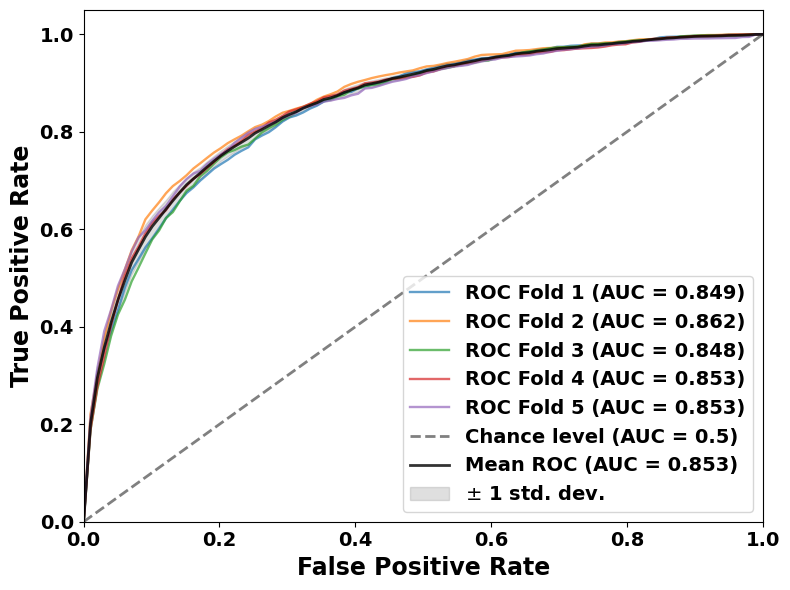

In [30]:
plot_roc_curves(test_preds, test_trues)